**1. Connect Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2. Downloading and importing libraries**

In [ ]:
# Installing the necessary libraries.
!pip install numpy scipy scikit-learn keras keras_preprocessing librosa
# Importing downloaded libraries.
import glob
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.signal as signal
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

**3. Loading a dataset**

In [ ]:
data_directory = "/content/drive/MyDrive/Team_materials_Hypothesis_1/emg_data/"

# Check if the dataset has already been downloaded
# (assuming that all files in the directory have already been downloaded).
if os.listdir(data_directory):
  print("The dataset has already been downloaded!")
else:
  # Download the dataset.
  !wget https://zenodo.org/records/4064409/files/emg_data.tar.gz

  # Check if the dataset downloaded correctly.
  if os.path.exists("emg_data.tar.gz"):
    print("Dataset downloaded successfully!")
    !tar -xzf emg_data.tar.gz
    print("Files extracted.")
  else:
    print("Error when downloading dataset!")

The dataset has already been downloaded!


**4. Analysing data files**

In [ ]:
# Define the directory where the dataset is stored.
data_directory = "/content/drive/MyDrive/Team_materials_Hypothesis_1/emg_data/closed_vocab/silent/5-19_silent"
os.chdir(data_directory)
# Print all files in current directory.
files_list = glob.glob("*")
print(files_list)

# Initialise counters for each type of file.
audio_count = 0
audio_clean_count = 0
button_count = 0
emg_count = 0
info_count = 0

# Count file by type.
for file in files_list:
  if file.endswith("_audio.flac"):
    audio_count += 1
  elif file.endswith("_audio_clean.flac"):
    audio_clean_count += 1
  elif file.endswith("_button.npy"):
    button_count += 1
  elif file.endswith("_emg.npy"):
    emg_count += 1
  elif file.endswith("_info.json"):
    info_count += 1

# Print the numbers of files of each type.
print(f"Audio files count: {audio_count}")
print(f"Clean audio files count: {audio_clean_count}")
print(f"Button files count: {button_count}")
print(f"EMG files count: {emg_count}")
print(f"Info files count: {info_count}")
print(f".flac files count: {audio_count + audio_clean_count}")
print(f".npy files count: {button_count + emg_count}")
print(f"Total number of files: {audio_count + audio_clean_count + button_count + emg_count + info_count}")

['345_info.json', '362_button.npy', '509_info.json', '683_emg.npy', '629_emg.npy', '562_button.npy', '429_emg.npy', '363_audio_clean.flac', '374_emg.npy', '448_audio_clean.flac', '468_info.json', '645_audio_clean.flac', '360_audio_clean.flac', '518_audio_clean.flac', '35_emg.npy', '381_emg.npy', '370_audio_clean.flac', '545_button.npy', '426_emg.npy', '442_audio.flac', '361_emg.npy', '532_emg.npy', '629_audio_clean.flac', '99_button.npy', '469_audio.flac', '72_audio_clean.flac', '397_info.json', '427_info.json', '238_emg.npy', '407_info.json', '671_button.npy', '443_audio.flac', '77_info.json', '74_audio_clean.flac', '664_info.json', '534_audio.flac', '526_emg.npy', '395_audio_clean.flac', '82_emg.npy', '673_emg.npy', '421_audio.flac', '369_audio.flac', '333_audio.flac', '43_audio_clean.flac', '409_emg.npy', '446_audio_clean.flac', '244_audio.flac', '549_emg.npy', '497_emg.npy', '89_audio_clean.flac', '97_info.json', '559_audio_clean.flac', '569_emg.npy', '78_audio_clean.flac', '397_em

**5. Data preprocessing**

In [ ]:
frequency = 1000
low = 20
high = 450
all_emg_data, all_audio_data = [], []

for emg_file in glob.glob("*_emg.npy"):
    audio_file = emg_file.replace("_emg.npy", "_audio.flac")
    info_file = emg_file.replace("_emg.npy", "_info.json")

    if os.path.exists(audio_file) and os.path.exists(info_file):
        with open(info_file, "r") as f:
            info_data = json.load(f)

            # Skip file with sentence_index == -1.
            if info_data["sentence_index"] == -1:
                continue

        # Load EMG data.
        emg_data = np.load(emg_file)

        # Load audio data without preprocessing.
        audio_data, sample_rate = librosa.load(audio_file)
        audio_data = audio_data[:, np.newaxis]

        all_emg_data.append(emg_data.reshape((emg_data.shape[0], emg_data.shape[1], 1)))
        all_audio_data.append(audio_data[:, np.newaxis])

# Concatenate all data.
all_emg_data = np.concatenate(all_emg_data, axis=0)
all_audio_data = np.concatenate(all_audio_data, axis=0)
print("Data preprocessing was successful.")

Data preprocessing was successful.


**6. Distribution of EMG signal values before normalization**

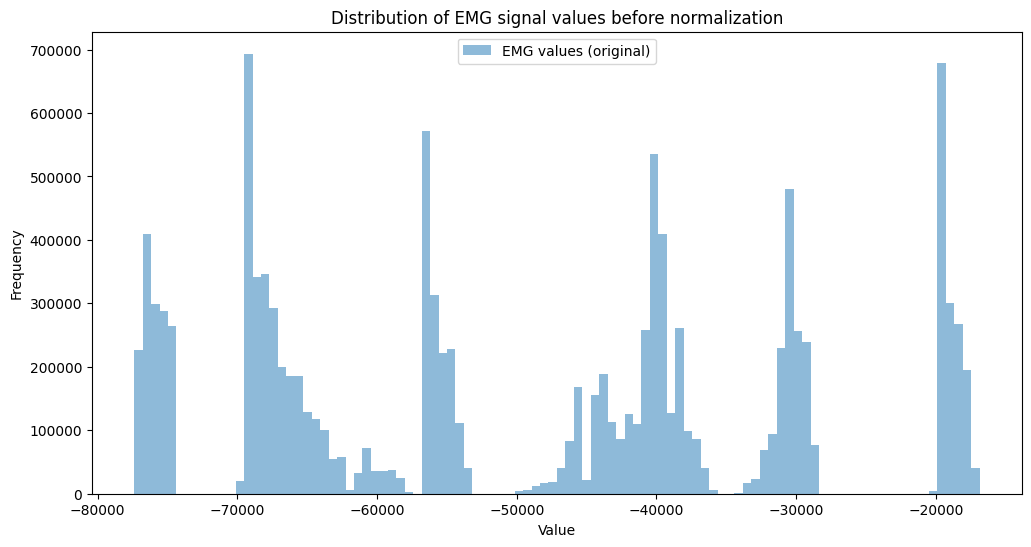

In [ ]:
emg_values = all_emg_data.flatten()

plt.figure(figsize=(12, 6))
plt.hist(emg_values, bins=100, alpha=0.5, label="EMG values (original)")
plt.title("Distribution of EMG signal values before normalization")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**7. Application of pad_sequences and data scaling**

In [ ]:
# Apply pad_sequences.
all_emg_data_padded = pad_sequences(all_emg_data)

# Reshape from 3D to 2D for scaling.
nsamples, nx, ny = all_emg_data_padded.shape
all_emg_data_reshaped = all_emg_data_padded.reshape((nsamples, nx * ny))

# Apply MinMaxScaler.
scaler_audio = MinMaxScaler(feature_range=(-1, 1))
all_audio_data_scaled = scaler_audio.fit_transform(all_emg_data_reshaped)

# Reshape back to 3D if necessary for the LSTM input.
all_audio_data_scaled = all_audio_data_scaled.reshape((nsamples, nx, ny))
print("The application of pad_sequences and scaling has been successfully completed.")

The application of pad_sequences and scaling has been successfully completed.


**8. Distribution of EMG signal values after normalization**

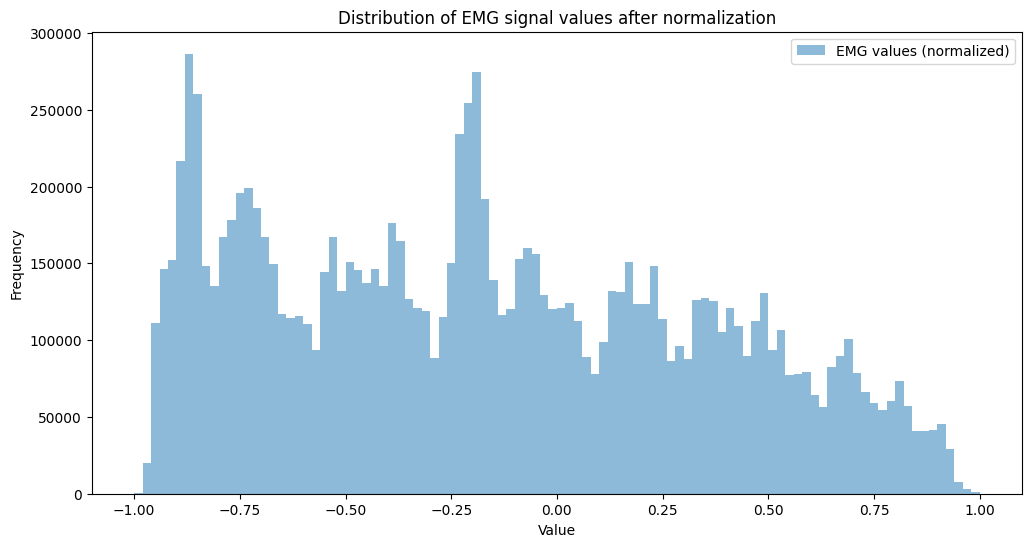

In [ ]:
emg_values_normalized = all_audio_data_scaled.flatten()

plt.figure(figsize=(12, 6))
plt.hist(emg_values_normalized, bins=100, alpha=0.5, label="EMG values (normalized)")
plt.title("Distribution of EMG signal values after normalization")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

**9. Split data into training and test data**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(all_emg_data_padded, all_audio_data_scaled, test_size=0.2, random_state=42)

**10. Creating and defining a model**

In [ ]:
input_shape = (all_emg_data.shape[1], 1)
output_dim = all_audio_data_scaled.shape[1]
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(output_dim))
model.compile(loss="mean_squared_error", optimizer="adam")
print("The model has been successfully created.")

The model has been successfully created.


**11. Training of the model**

In [ ]:
history = model.fit(np.array(x_train), np.array(y_train),
                    epochs=10, batch_size=32,
                    validation_data=(np.array(x_test), np.array(y_test)),
                    verbose=1)

Epoch 1/10
37163/37163 [==============================] - 193s 5ms/step - loss: 0.2000 - val_loss: 0.2004
Epoch 2/10
37163/37163 [==============================] - 189s 5ms/step - loss: 0.1998 - val_loss: 0.2004
Epoch 3/10
37163/37163 [==============================] - 188s 5ms/step - loss: 0.1998 - val_loss: 0.2004
Epoch 4/10
37163/37163 [==============================] - 188s 5ms/step - loss: 0.1998 - val_loss: 0.2004
Epoch 5/10
37163/37163 [==============================] - 187s 5ms/step - loss: 0.1998 - val_loss: 0.2004
Epoch 6/10
37163/37163 [==============================] - 188s 5ms/step - loss: 0.1998 - val_loss: 0.2003
Epoch 7/10
37163/37163 [==============================] - 187s 5ms/step - loss: 0.1998 - val_loss: 0.2008
Epoch 8/10
37163/37163 [==============================] - 188s 5ms/step - loss: 0.1998 - val_loss: 0.2004
Epoch 9/10
37163/37163 [==============================] - 188s 5ms/step - loss: 0.1998 - val_loss: 0.2004
Epoch 10/10
37163/37163 [=====================

**12. Saving the model**

In [ ]:
directory_to_save = "/content/drive/MyDrive/Team_materials_Hypothesis_1/models"
os.chdir(directory_to_save)
model.save(f"{directory_to_save}/trained_model_opensource_dataset.keras")
print("Saving of the model is complete.")

Saving of the model is complete.


**13. Plotting graphs**

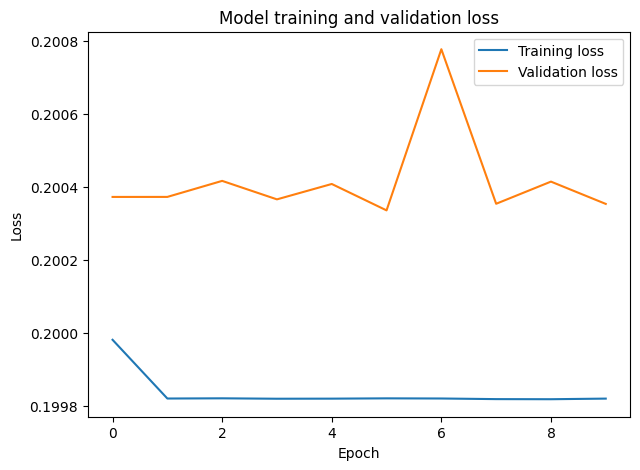

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("Model training and validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

**14. Evaluating the model**

In [ ]:
# Make predictions on the test set.
y_pred = model.predict(x_test)
y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1])

# Calculate MSE.
mse = mean_squared_error(y_test_reshaped, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE.
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE.
mae = mean_absolute_error(y_test_reshaped, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

9291/9291 [==============================] - 20s 2ms/step
Mean Squared Error (MSE): 0.200352906686858
Root Mean Squared Error (RMSE): 0.4476079832698005
Mean Absolute Error (MAE): 0.362252106037579
